# Step 1: Storing Data with Hub
In this first section, we create a `hub.Dataset` object on our local machine. Thereafter, we will manipulate our data through this `Dataset` object.

In [7]:
import hub
from hub.schema import ClassLabel, Image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, we define a data schema called `my_schema`. 

`my_schema` describes our dataset at a high level. In this example, our dataset consists of two collections: `image` and `label`. Each `image` in our dataset has the shape (10, 10) and can take on one of five labels.

In [8]:
my_schema = {
    "image": Image(shape=(10, 10), dtype="uint8"),
    "label": ClassLabel(num_classes=5),
}

We define a `tag` (we call it `"mynameisvinn/example"` but you can name it anything). This `tag` refers to the Hub repo where our dataset is stored.

In [9]:
tag = "mynameisvinn/example"

Now that we have described our dataset at a high level, we can create a `hub.Dataset` called `ds`.

`ds` will be our primary way of interacting with Hub.

In [10]:
n_examples = 100
ds = hub.Dataset(tag, shape=(n_examples,), schema=my_schema, mode="w")

We can treat `ds` as a pandas dataframe and populate it. In this example, we populate it with randomly generated matrics.

In [11]:
for i in range(100):
    ds["image", i] = np.random.randint(0, 255, (10, 10), dtype="uint8")
    ds["label", i] = np.random.randint(5)

Let's inspect our dataset:

Text(0.5, 1.0, 'label4')

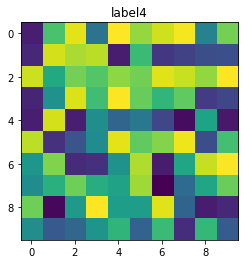

In [12]:
img = ds["image", 5].compute()
plt.imshow(img)
plt.title("label" + str(ds["label", 5].compute()))

By calling `ds.commit()`, we *commit* our dataset to a remote data store (perhaps s3). This remote data store can be identified by its tag (in this case, `mynameisvinn/examaple`).

In [13]:
ds.commit()

Finally, we remove `ds` with `ds.close()`.

In [14]:
ds.close()

# Step 2: Remotely manipulating data
Now we want to transform our dataset in some way. 

Perhaps we want to flatten images before feeding it to a convolutional network). We can apply a reshaping function to our remote data and then pull in the results.

Because we are modifying our data, we will need a new data schema:

In [15]:
new_schema = {
    "image": Image(shape=(1, 100), dtype="uint8"),
    "label": ClassLabel(num_classes=5),
}

After defining our transformation (`my_transform`), we decorate it with `hub.transform`.

In [16]:
@hub.transform(schema=new_schema)
def my_transform(sample):
    return {
        "image": sample['image'].compute().reshape(1, 100),
        "label": sample["label"].compute()
       }

Invoking this decorated method returns a `transform` object.

In [17]:
out_ds = my_transform(ds)  # returns a transform object

Let's inspect the result:

In [18]:
out_ds['image', 0].compute().shape  # we can view the results of the operation

Computing the transormation: 100%|██████████| 1.00/1.00 [00:00<00:00, 27.8 items/s]


(1, 100)

If desired, we can push the results to a new data store:

In [73]:
res_ds = out_ds.store("mynameisvinn/example3")  # write results back to activeloop

Computing the transormation: 110 items [00:01, 75.0 items/s]               
